In [1]:
import os
import gc
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from ezc3d import c3d
from scipy.signal import resample
from scipy.io import loadmat, savemat
from scipy import sparse
from scipy.sparse.linalg import spsolve
from joblib import load, dump
from tqdm import tqdm
from scipy.signal import butter, lfilter, medfilt

# Constants

In [2]:
PATH_DATASETS = '../../Dataset/'
PATH_DATASET_2 = 'gait-dbase-2/'

N_SAMPLES = 1024
FORCE_THRESHOLD = 20
TOE_HEIGTH_THRESHOLD = 40

# Filter

In [3]:
class LowPassFilter(object): 
    @staticmethod
    def butter_lowpass(cutoff, fs, order):
        nyq = 0.5 * fs
        normal_cutoff = cutoff / nyq
        b, a = butter(order, normal_cutoff, btype='low', analog=False)
        return b, a

    def apply(data, cutoff=6, fs=2000, order=2, axis=-1):
        b, a = LowPassFilter.butter_lowpass(cutoff, fs, order=order)
        y = lfilter(b, a, data, axis=axis)
        y = y - np.median(y)
        return y

# Function Defs

In [4]:
def standardize(x):
    # return (x - np.mean(x, axis=0)) / np.std(x, axis=0)
    return (x - np.min(x, axis=0)) / (np.max(x, axis=0) - np.min(x, axis=0))

def require_positive(x):
    if x < 0:
        return 0
    else:
        return x

def clip_overflow(x, max=N_SAMPLES):
    if x >= max:
        return N_SAMPLES - 1
    else:
        return x

def clip_noise(x, min=FORCE_THRESHOLD):
    mask = x > min
    new_x = np.zeros(x.shape)
    new_x[mask] = x[mask]
    return new_x

def get_first_grf(x, swing_period):
    half_way = x.shape[0] / 2
    temp = np.zeros(x.shape)
    temp[:half_way] = x[:half_way]
    stance_mask = temp < FORCE_THRESHOLD
    stance_start = np.min(stance_mask == True)
    stance_end = np.max(stance_mask == True)
    roi_start = stance_start
    roi_end = stance_end + swing_period
    return temp[roi_start : roi_end]

def get_processed_grf(grf, clip=False):
    processed_grf = LowPassFilter.apply(grf, fs=2000, cutoff=20)
    if clip:
        processed_grf[processed_grf < FORCE_THRESHOLD] = 0
    return resample(processed_grf, N_SAMPLES * 4, axis=0).T

def get_processed_moment(moment):
    processed_moment = LowPassFilter.apply(moment, fs=2000, cutoff=20)
    return resample(processed_moment, N_SAMPLES * 4, axis=0).T
    

In [5]:
# Use trajectories-z 6-9 for y-axis

def get_trajectories(content, foot='right'):
    if foot == 'right':
        trajectory_x = content['data']['points'][0, 18:23, :]
        trajectory_y = content['data']['points'][1, 18:23, :]
        trajectory_z = content['data']['points'][2, 18:23, :]

    elif foot == 'left':
        trajectory_x = content['data']['points'][0, 6:11, :]
        trajectory_y = content['data']['points'][1, 6:11, :]
        trajectory_z = content['data']['points'][2, 6:11, :]

    else:
        raise ValueError('Third foot is not allowed')

    # trajectory_x = LowPassFilter.apply(trajectory_x, fs=200, cutoff=20)
    # trajectory_y = LowPassFilter.apply(trajectory_y, fs=200, cutoff=20)
    # trajectory_z = LowPassFilter.apply(trajectory_z, fs=200, cutoff=20)

    trajectory_x = resample(trajectory_x, N_SAMPLES * 4, axis=1).T
    trajectory_y = resample(trajectory_y, N_SAMPLES * 4, axis=1).T
    trajectory_z = resample(trajectory_z, N_SAMPLES * 4, axis=1).T

    return trajectory_x, trajectory_y, trajectory_z

def get_force(content):
    force_x = []
    force_y = []
    force_z = []
    for i in range(1, 5):
        force_x.append(
            get_processed_grf(
                content['data']['platform'][i]['force'][0, :]
            )
        )
        force_y.append(
            get_processed_grf(
                content['data']['platform'][i]['force'][1, :]
            )
        )
        force_z.append(
            get_processed_grf(
                content['data']['platform'][i]['force'][2, :], True
            )
        )

    return force_x, force_y, force_z

def get_moment(content):
    moment_x = []
    moment_y = []
    moment_z = []
    for i in range(1, 5):
        moment_x.append(
            get_processed_moment(
                content['data']['platform'][i]['moment'][0, :]
            )
        )
        moment_y.append(
            get_processed_moment(
                content['data']['platform'][i]['moment'][1, :]
            )
        )
        moment_z.append(
            get_processed_moment(
                content['data']['platform'][i]['moment'][2, :]
            )
        )

    return moment_x, moment_y, moment_z

def get_swing_period(force_plate_data_z):
    grf_combined_z_r = force_plate_data_z[0] + force_plate_data_z[2]
    grf_combined_z_l = force_plate_data_z[1] + force_plate_data_z[3]

    grf_mask_r = (grf_combined_z_r >= FORCE_THRESHOLD)
    grf_mask_l = (grf_combined_z_l >= FORCE_THRESHOLD)

    grf_start_r = np.min(np.argwhere(grf_mask_r == True))
    grf_end_r = np.max(np.argwhere(grf_mask_r == True))
    grf_start_l = np.min(np.argwhere(grf_mask_l == True))
    grf_end_l = np.max(np.argwhere(grf_mask_l == True))

    swing_period_r = np.sum(grf_combined_z_r[grf_start_r:grf_end_r] <= FORCE_THRESHOLD)
    swing_period_l = np.sum(grf_combined_z_l[grf_start_l:grf_end_l] <= FORCE_THRESHOLD)

    return swing_period_r, swing_period_l
    

# Test Bench

In [6]:
path = '/home/ai/Python/GRF-Synthesis-from-Motion-Trajectories/Dataset/gait-dbase-2/Participant3/Raw_Data/V35/T1.c3d'

In [7]:
content = c3d(path, extract_forceplat_data=True)

# Extract Features

In [8]:
path = os.path.join(PATH_DATASETS, PATH_DATASET_2)
subjects = os.listdir(path)

# subjects = subjects[:8]

features = pd.DataFrame()
target = pd.DataFrame()

records = []
n_samples = 0
n_bad_samples = 0

for subject in tqdm(subjects):
    velocities_path = os.path.join(path, subject, 'Raw_Data')
    velocities = os.listdir(velocities_path)

    for velocity in velocities:

        # if 'V1' in velocity or 'V15' in velocity or 'V2' in velocity or 'V25' in velocity:
        #     continue

        files_path = os.path.join(velocities_path, velocity)
        files = os.listdir(files_path)

        for filename in files:
            try:
                content = c3d(os.path.join(files_path, filename), extract_forceplat_data=True)
                
                trajectory_x_r, trajectory_y_r, trajectory_z_r = get_trajectories(content, 'right')
                trajectory_x_l, trajectory_y_l, trajectory_z_l = get_trajectories(content, 'left')

                force_x, force_y, force_z = get_force(content)
                # moment_x, moment_y, moment_z = get_moment(content)
                swing_period_r, swing_period_l = get_swing_period(force_z)

                del content
                gc.collect()

                mask_force_z_r_1 = (force_z[0] > FORCE_THRESHOLD)
                mask_force_z_r_2 = (force_z[2] > FORCE_THRESHOLD)
                mask_force_z_l_1 = (force_z[1] > FORCE_THRESHOLD)
                mask_force_z_l_2 = (force_z[3] > FORCE_THRESHOLD)

                # ----------------------- RIGHT ------------------------

                start = np.min(np.argwhere(mask_force_z_r_1 == True))
                end = np.max(np.argwhere(mask_force_z_r_1 == True)) # + swing_period_r

                force_x_r_1 = -force_x[0][start : end]
                force_y_r_1 = force_y[0][start : end]
                force_z_r_1 = force_z[0][start : end]

                # moment_x_r_1 = moment_x[0][start : end]
                # moment_y_r_1 = moment_y[0][start : end]
                # moment_z_r_1 = moment_z[0][start : end]

                trajectory_x_r_1 = trajectory_x_l[start:end]
                trajectory_y_r_1 = trajectory_y_r[start:end]
                trajectory_z_r_1 = trajectory_z_r[start:end]

                start = np.min(np.argwhere(mask_force_z_r_2 == True))
                end = np.max(np.argwhere(mask_force_z_r_2 == True)) # + swing_period_r

                force_x_r_2 = -force_x[2][start : end]
                force_y_r_2 = force_y[2][start : end]
                force_z_r_2 = force_z[2][start : end]

                # moment_x_r_2 = moment_x[2][start : end]
                # moment_y_r_2 = -moment_y[2][start : end]
                # moment_z_r_2 = -moment_z[2][start : end]

                trajectory_x_r_2 = trajectory_x_l[start:end]
                trajectory_y_r_2 = trajectory_y_r[start:end]
                trajectory_z_r_2 = trajectory_z_r[start:end]


                # ----------------------- LEFT ------------------------

                start = np.min(np.argwhere(mask_force_z_l_1 == True))
                end = np.max(np.argwhere(mask_force_z_l_1 == True)) # + swing_period_l

                force_x_l_1 = force_x[1][start : end]
                force_y_l_1 = force_y[1][start : end]
                force_z_l_1 = force_z[1][start : end]

                # moment_x_l_1 = moment_x[1][start : end]
                # moment_y_l_1 = moment_y[1][start : end]
                # moment_z_l_1 = moment_z[1][start : end]

                trajectory_x_l_1 = trajectory_x_r[start:end]
                trajectory_y_l_1 = trajectory_y_l[start:end]
                trajectory_z_l_1 = trajectory_z_l[start:end]

                start = np.min(np.argwhere(mask_force_z_l_2 == True))
                end = np.max(np.argwhere(mask_force_z_l_2 == True)) # + swing_period_l

                force_x_l_2 = force_x[3][start : end]
                force_y_l_2 = force_y[3][start : end]
                force_z_l_2 = force_z[3][start : end]

                # moment_x_l_2 = moment_x[3][start : end]
                # moment_y_l_2 = -moment_y[3][start : end]
                # moment_z_l_2 = -moment_z[3][start : end]

                trajectory_x_l_2 = trajectory_x_r[start:end]
                trajectory_y_l_2 = trajectory_y_l[start:end]
                trajectory_z_l_2 = trajectory_z_l[start:end]


                # ... Remove all zero GRF samples
                # if np.mean(force_z_2) <= FORCE_THRESHOLD or np.mean(force_z_3) <= FORCE_THRESHOLD \
                #     or np.mean(force_z_4) <= FORCE_THRESHOLD or np.mean(force_z_5) <= FORCE_THRESHOLD:
                #     n_bad_samples = n_bad_samples + 1
                #     continue

                
                # ... Resample
                force_x_r_1 = resample(force_x_r_1, N_SAMPLES, axis=0)
                force_x_l_1 = resample(force_x_l_1, N_SAMPLES, axis=0)
                force_x_r_2 = resample(force_x_r_2, N_SAMPLES, axis=0)
                force_x_l_2 = resample(force_x_l_2, N_SAMPLES, axis=0)

                force_y_r_1 = resample(force_y_r_1, N_SAMPLES, axis=0)
                force_y_l_1 = resample(force_y_l_1, N_SAMPLES, axis=0)
                force_y_r_2 = resample(force_y_r_2, N_SAMPLES, axis=0)
                force_y_l_2 = resample(force_y_l_2, N_SAMPLES, axis=0)

                force_z_r_1 = resample(force_z_r_1, N_SAMPLES, axis=0)
                force_z_l_1 = resample(force_z_l_1, N_SAMPLES, axis=0)
                force_z_r_2 = resample(force_z_r_2, N_SAMPLES, axis=0)
                force_z_l_2 = resample(force_z_l_2, N_SAMPLES, axis=0)

                trajectory_x_r_1 = resample(trajectory_x_r_1, N_SAMPLES, axis=0)
                trajectory_x_r_2 = resample(trajectory_x_r_2, N_SAMPLES, axis=0)
                trajectory_x_l_1 = resample(trajectory_x_l_1, N_SAMPLES, axis=0)
                trajectory_x_l_2 = resample(trajectory_x_l_2, N_SAMPLES, axis=0)

                trajectory_y_r_1 = resample(trajectory_y_r_1, N_SAMPLES, axis=0)
                trajectory_y_r_2 = resample(trajectory_y_r_2, N_SAMPLES, axis=0)
                trajectory_y_l_1 = resample(trajectory_y_l_1, N_SAMPLES, axis=0)
                trajectory_y_l_2 = resample(trajectory_y_l_2, N_SAMPLES, axis=0)

                trajectory_z_r_1 = resample(trajectory_z_r_1, N_SAMPLES, axis=0)
                trajectory_z_r_2 = resample(trajectory_z_r_2, N_SAMPLES, axis=0)
                trajectory_z_l_1 = resample(trajectory_z_l_1, N_SAMPLES, axis=0)
                trajectory_z_l_2 = resample(trajectory_z_l_2, N_SAMPLES, axis=0)

                # ... Standardize
                force_x_r_1 = standardize(force_x_r_1)
                force_x_l_1 = standardize(force_x_l_1)
                force_x_r_2 = standardize(force_x_r_2)
                force_x_l_2 = standardize(force_x_l_2)

                force_y_r_1 = standardize(force_y_r_1)
                force_y_l_1 = standardize(force_y_l_1)
                force_y_r_2 = standardize(force_y_r_2)
                force_y_l_2 = standardize(force_y_l_2)

                force_z_r_1 = standardize(force_z_r_1)
                force_z_l_1 = standardize(force_z_l_1)
                force_z_r_2 = standardize(force_z_r_2)
                force_z_l_2 = standardize(force_z_l_2)

                trajectory_x_r_1 = standardize(trajectory_x_r_1)
                trajectory_x_r_2 = standardize(trajectory_x_r_2)
                trajectory_x_l_1 = standardize(trajectory_x_l_1)
                trajectory_x_l_2 = standardize(trajectory_x_l_2)

                trajectory_y_r_1 = standardize(trajectory_y_r_1)
                trajectory_y_r_2 = standardize(trajectory_y_r_2)
                trajectory_y_l_1 = standardize(trajectory_y_l_1)
                trajectory_y_l_2 = standardize(trajectory_y_l_2)

                trajectory_z_r_1 = standardize(trajectory_z_r_1)
                trajectory_z_r_2 = standardize(trajectory_z_r_2)
                trajectory_z_l_1 = standardize(trajectory_z_l_1)
                trajectory_z_l_2 = standardize(trajectory_z_l_2)

                _features_l_1 = pd.DataFrame(
                    np.concatenate([trajectory_x_l_1, trajectory_y_l_1, trajectory_z_l_1], axis=1),
                    columns=[
                        # '0_x', '1_x', '2_x', '3_x', '4_x', '5_x', '6_x', '7_x', '8_x', '9_x', '10_x', '11_x',
                        # '0_y', '1_y', '2_y', '3_y', '4_y', '5_y', '6_y', '7_y', '8_y', '9_y', '10_y', '11_y',
                        # '0_z', '1_z', '2_z', '3_z', '4_z', '5_z', '6_z', '7_z', '8_z', '9_z', '10_z', '11_z'
                        'fal_x', 'tam_x', 'fm5_x', 'fm1_x', 'fm2_x',
                        'fal_y', 'tam_y', 'fm5_y', 'fm1_y', 'fm2_y',
                        'fal_z', 'tam_z', 'fm5_z', 'fm1_z', 'fm2_z'
                    ]
                )

                _features_l_2 = pd.DataFrame(
                    np.concatenate([trajectory_x_l_2, trajectory_y_l_2, trajectory_z_l_2], axis=1),
                    columns=[
                        # '0_x', '1_x', '2_x', '3_x', '4_x', '5_x', '6_x', '7_x', '8_x', '9_x', '10_x', '11_x',
                        # '0_y', '1_y', '2_y', '3_y', '4_y', '5_y', '6_y', '7_y', '8_y', '9_y', '10_y', '11_y',
                        # '0_z', '1_z', '2_z', '3_z', '4_z', '5_z', '6_z', '7_z', '8_z', '9_z', '10_z', '11_z'
                        'fal_x', 'tam_x', 'fm5_x', 'fm1_x', 'fm2_x',
                        'fal_y', 'tam_y', 'fm5_y', 'fm1_y', 'fm2_y',
                        'fal_z', 'tam_z', 'fm5_z', 'fm1_z', 'fm2_z'
                    ]
                )

                _features_r_1 = pd.DataFrame(
                    np.concatenate([trajectory_x_r_1, trajectory_y_r_1, trajectory_z_r_1], axis=1),
                    columns=[
                        # '0_x', '1_x', '2_x', '3_x', '4_x', '5_x', '6_x', '7_x', '8_x', '9_x', '10_x', '11_x',
                        # '0_y', '1_y', '2_y', '3_y', '4_y', '5_y', '6_y', '7_y', '8_y', '9_y', '10_y', '11_y',
                        # '0_z', '1_z', '2_z', '3_z', '4_z', '5_z', '6_z', '7_z', '8_z', '9_z', '10_z', '11_z'
                        'fal_x', 'tam_x', 'fm5_x', 'fm1_x', 'fm2_x',
                        'fal_y', 'tam_y', 'fm5_y', 'fm1_y', 'fm2_y',
                        'fal_z', 'tam_z', 'fm5_z', 'fm1_z', 'fm2_z'
                    ]
                )

                _features_r_2 = pd.DataFrame(
                    np.concatenate([trajectory_x_r_2, trajectory_y_r_2, trajectory_z_r_2], axis=1),
                    columns=[
                        # '0_x', '1_x', '2_x', '3_x', '4_x', '5_x', '6_x', '7_x', '8_x', '9_x', '10_x', '11_x',
                        # '0_y', '1_y', '2_y', '3_y', '4_y', '5_y', '6_y', '7_y', '8_y', '9_y', '10_y', '11_y',
                        # '0_z', '1_z', '2_z', '3_z', '4_z', '5_z', '6_z', '7_z', '8_z', '9_z', '10_z', '11_z'
                        'fal_x', 'tam_x', 'fm5_x', 'fm1_x', 'fm2_x',
                        'fal_y', 'tam_y', 'fm5_y', 'fm1_y', 'fm2_y',
                        'fal_z', 'tam_z', 'fm5_z', 'fm1_z', 'fm2_z'
                    ]
                )

                _features = pd.concat([_features_l_1, _features_l_2, _features_r_1, _features_r_2], axis=0)

                _target_r_1 = pd.DataFrame(
                    np.stack([force_x_r_1, force_y_r_1, force_z_r_1], axis=1),
                    columns=['fx', 'fy', 'fz']
                )

                _target_r_2 = pd.DataFrame(
                    np.stack([force_x_r_2, force_y_r_2, force_z_r_2], axis=1),
                    columns=['fx', 'fy', 'fz']
                )

                _target_l_1 = pd.DataFrame(
                    np.stack([force_x_l_1, force_y_l_1, force_z_l_1], axis=1),
                    columns=['fx', 'fy', 'fz']
                )

                _target_l_2 = pd.DataFrame(
                    np.stack([force_x_l_2, force_y_l_2, force_z_l_2], axis=1),
                    columns=['fx', 'fy', 'fz']
                )

                _target = pd.concat([_target_r_1, _target_r_2, _target_l_1, _target_l_2], axis=0)

                features = pd.concat([features, _features], axis=0, ignore_index=True)
                target = pd.concat([target, _target], axis=0, ignore_index=True)

                records.append(filename)

                n_samples = n_samples + 1

            except Exception as e:
                print(f'ERROR [{subject}/{velocity}/{filename}]: {e}')
                n_bad_samples = n_bad_samples + 1
                pass

print('Number of good samples: ', n_samples)
print('Number of bad samples: ', n_bad_samples)

  6%|▋         | 1/16 [00:52<13:09, 52.67s/it]

ERROR [Participant4/V1/T2.c3d]: Shape of passed values is (1024, 14), indices imply (1024, 15)
ERROR [Participant4/V1/T1.c3d]: Shape of passed values is (1024, 14), indices imply (1024, 15)
ERROR [Participant4/V1/T7.c3d]: Shape of passed values is (1024, 14), indices imply (1024, 15)
ERROR [Participant4/V1/T4.c3d]: Shape of passed values is (1024, 14), indices imply (1024, 15)
ERROR [Participant4/V1/T8.c3d]: Shape of passed values is (1024, 14), indices imply (1024, 15)
ERROR [Participant4/V1/T6.c3d]: Shape of passed values is (1024, 14), indices imply (1024, 15)
ERROR [Participant4/V1/T3.c3d]: Shape of passed values is (1024, 14), indices imply (1024, 15)
ERROR [Participant4/V1/T9.c3d]: zero-size array to reduction operation minimum which has no identity
ERROR [Participant4/V1/T5.c3d]: Shape of passed values is (1024, 14), indices imply (1024, 15)


 12%|█▎        | 2/16 [01:38<11:22, 48.78s/it]

ERROR [Participant11/V15/T6.c3d]: zero-size array to reduction operation minimum which has no identity
ERROR [Participant11/V1/T8.c3d]: zero-size array to reduction operation minimum which has no identity


 19%|█▉        | 3/16 [02:36<11:27, 52.86s/it]

ERROR [Participant14/V25/T2.c3d]: Shape of passed values is (1024, 14), indices imply (1024, 15)
ERROR [Participant14/V25/T1.c3d]: Shape of passed values is (1024, 14), indices imply (1024, 15)
ERROR [Participant14/V25/T7.c3d]: Shape of passed values is (1024, 14), indices imply (1024, 15)
ERROR [Participant14/V25/T10.c3d]: Shape of passed values is (1024, 14), indices imply (1024, 15)
ERROR [Participant14/V25/T4.c3d]: Shape of passed values is (1024, 14), indices imply (1024, 15)
ERROR [Participant14/V25/T8.c3d]: Shape of passed values is (1024, 14), indices imply (1024, 15)
ERROR [Participant14/V25/T6.c3d]: Shape of passed values is (1024, 14), indices imply (1024, 15)
ERROR [Participant14/V25/T3.c3d]: Shape of passed values is (1024, 14), indices imply (1024, 15)
ERROR [Participant14/V25/T9.c3d]: Shape of passed values is (1024, 14), indices imply (1024, 15)
ERROR [Participant14/V25/T5.c3d]: Shape of passed values is (1024, 14), indices imply (1024, 15)
ERROR [Participant14/V4/T2.c3

 25%|██▌       | 4/16 [03:32<10:49, 54.09s/it]

ERROR [Participant14/V2/T5.c3d]: Shape of passed values is (1024, 14), indices imply (1024, 15)


100%|██████████| 16/16 [14:59<00:00, 56.19s/it]

Number of good samples:  980
Number of bad samples:  80


In [9]:
velocity

'V2'

In [10]:
features

,fal_x,tam_x,fm5_x,fm1_x,fm2_x,fal_y,tam_y,fm5_y,fm1_y,fm2_y,fal_z,tam_z,fm5_z,fm1_z,fm2_z
0,0.771199,0.579231,0.534513,0.008004,0.015918,0.049558,0.049639,0.049514,0.049928,0.050077,0.053459,0.121212,0.286677,0.189086,0.204209
1,0.818889,0.620615,0.570670,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014679,0.093220,0.257370,0.198398,0.216687
2,0.739741,0.568240,0.518998,0.094547,0.094946,0.106339,0.106205,0.106325,0.105825,0.105598,0.090632,0.148181,0.308674,0.183171,0.195856
3,0.826794,0.639989,0.582024,0.051443,0.043874,0.006912,0.006725,0.006928,0.006158,0.005785,0.015837,0.094455,0.254565,0.200294,0.218851
4,0.774722,0.608523,0.548885,0.121203,0.115013,0.078572,0.078259,0.078533,0.077364,0.076759,0.066595,0.131449,0.289241,0.190533,0.205284
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4014075,0.526643,0.239677,0.382744,0.603243,0.309229,0.895130,0.895509,0.895412,0.895459,0.895471,0.364372,0.006107,0.017280,0.175009,0.170095
4014076,0.555651,0.253510,0.402059,0.632673,0.299104,0.945139,0.945372,0.945314,0.945330,0.945337,0.383984,0.003249,0.018267,0.183431,0.179388
4014077,0.494890,0.225396,0.356246,0.561110,0.288284,0.841513,0.841676,0.841643,0.841665,0.841669,0.341501,0.008789,0.015992,0.166187,0.159688
4014078,0.588390,0.269541,0.421033,0.663293,0.282489,1.000000,1.000000,1.000000,1.000000,1.000000,0.405425,0.000000,0.018943,0.192531,0.189608


In [11]:
target

,fx,fy,fz
0,0.301478,0.529105,0.003522
1,0.294207,0.539680,0.008734
2,0.296560,0.540700,0.014890
3,0.285964,0.555552,0.022945
4,0.284951,0.560672,0.030800
...,...,...,...
4014075,0.296369,0.526270,0.014930
4014076,0.297774,0.521052,0.012680
4014077,0.294261,0.521179,0.008608
4014078,0.297797,0.513763,0.007592


In [12]:
path = '../../Dataset/Processed/data2_f15_t3_n1_all_vel.joblib'
data = {
    'X': features,
    'y': target
}
dump(data, path)

['../../Dataset/Processed/data2_f15_t3_n1_all_vel.joblib']

# Generating Train Test Sets

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from joblib import load, dump
from sklearn.model_selection import train_test_split

N_SAMPLES = 1024
N_CHANNELS = 15

path = '../../Dataset/Processed/data2_f15_t3_n1_all_vel.joblib'
data = load(path)
features = data['X']
target = data['y']

# path1 = '../../Dataset/Processed/data2_f72_t3_n1_p1.joblib'
# path2 = '../../Dataset/Processed/data2_f72_t3_n1_p2.joblib'

# data1 = load(path1)
# data2 = load(path2)

# features1 = data1['X']
# features2 = data2['X']

# target1 = data1['y']
# target2 = data2['y']

# print(features1.shape)
# print(features2.shape)

# print(target1.shape)
# print(target2.shape)

In [14]:
# x = features['11_z'].to_numpy().reshape(-1, N_SAMPLES)
# for i in range(1120, 1130):
#     plt.plot(x[i, :])

In [15]:
# features = pd.concat([features1, features2])
# target = pd.concat([target1, target2])

# print(features.shape)
# print(target.shape)

In [16]:
X = features.to_numpy().reshape(-1, N_SAMPLES, N_CHANNELS)
y = target.to_numpy().reshape(-1, N_SAMPLES, 3)

print(X.shape)
print(y.shape)

(3920, 1024, 15)
(3920, 1024, 3)


In [17]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)

print(train_X.shape)
print(test_X.shape)
print(train_y.shape)
print(test_y.shape)

(3136, 1024, 15)
(784, 1024, 15)
(3136, 1024, 3)
(784, 1024, 3)


In [18]:
path = '../../Dataset/Processed/data2_f15_t3_n1_all_vel_combined.joblib'
data = {
    'train_X': train_X,
    'test_X': test_X,
    'train_y': train_y,
    'test_y': test_y
}
dump(data, path)

['../../Dataset/Processed/data2_f15_t3_n1_all_vel_combined.joblib']

<h1 align="center">Verification</h1>

In [19]:
# path = '../../Dataset/Processed/data2_f15_t3_n1.joblib'
# data = load(path)

# features = data['X']
# target = data['y']

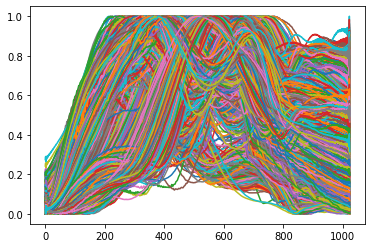

In [23]:
x = features['fal_z'].to_numpy().reshape(-1, N_SAMPLES)
for i in range(x.shape[0]):
    plt.plot(x[i, :])

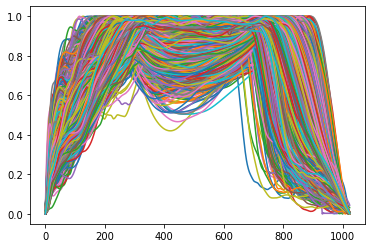

In [22]:
y = target['fz'].to_numpy().reshape(-1, N_SAMPLES)
for i in range(y.shape[0]):
    plt.plot(y[i, :])

In [ ]:
i

In [ ]:
features.shape